In [1]:
""" 
Adoptation for the model proposed here: https://skimai.com/fine-tuning-bert-for-sentiment-analysis/
- goemotions dataset support
- emotions mapping to the Plutchik's scale
- turned to multilabel classification with neutral class
"""

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
import torch
import random
import time
    
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from transformers import BertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn import metrics

from transformers import BertTokenizer, BertForPreTraining
#from  ipynb.fs.full.testing_func import calc_classes_confusion, plot_classes_confusion, print_metrics, pr_curves

In [2]:
data = pd.read_csv('goemotions_3.csv')
data.dropna(subset = ['text'], inplace = True)
class_names = data.columns[3:]


In [3]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [4]:
path = 'roberta-base'

In [5]:
data = data.loc[:, ['text','anger',  'fear', 'joy',   'sadness','surprise']]

In [6]:
data.text.head()

0    Worst ending ever! I won't spoil it but this o...
1                       Happy cake day u/sneakpeekbot!
2    Was he rejected because of his methodology or ...
3                                      thanks, I agree
4                      Why would you doubt it dumbass?
Name: text, dtype: object

In [7]:
labels = data.iloc[:, 1:].sum(axis = 1)

In [8]:
x = np.array(labels)

In [9]:
df = data.drop(np.where(labels == 0)[0])

In [10]:
labels = df.iloc[:,1:].values.astype(np.float32)

In [11]:
df.head()

,text,anger,fear,joy,sadness,surprise
4,Why would you doubt it dumbass?,1,0,0,0,0
6,[NAME] is a hungry little bastard.,1,0,0,0,0
9,Both parents were drunk. Where were the small ...,0,0,0,1,0
18,OMG! I can only imagine. I've gotten it into a...,0,0,0,0,1
29,ONLY FUCKING MERRILL WOULD MISS THAT,1,0,0,0,0


In [12]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", 
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", 
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                       "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", 
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", 
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                       "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                       "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", 
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", 
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'u.s':'america', 'e.g':'for example'}

punct = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-",
                 "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 
                 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '!':' '}

mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ',
                'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can',
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',
                'demonetisation': 'demonetization'}

In [13]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#!pip install contractions
import contractions
import re
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
#from wordcloud import WordCloud
def preprocess(sentence):
    stop_words = set(stopwords.words('english'))
    #print(sentence)
    #sentence =sentence.tolist()

    lemmatizer = WordNetLemmatizer()
    sentence = re.sub('[^A-z]', ' ', sentence)
    negative = ['not', 'neither', 'nor', 'but', 'however', 'although', 'nonetheless', 'despite', 'except',
                        'even though', 'yet']
    stop_words = [z for z in stop_words if z not in negative]
    preprocessed_tokens = [lemmatizer.lemmatize(contractions.fix(temp.lower())) for temp in sentence.split() if temp not in stop_words] #lemmatization
    return ' '.join([x for x in preprocessed_tokens]).strip()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Артур\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Артур\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
import os
import matplotlib.pyplot as plt
import re
import string
import json
import emoji
import numpy as np
import pandas as pd
from sklearn import metrics
from bs4 import BeautifulSoup
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW
import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)
def clean_text(text):
    '''Clean emoji, Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = emoji.demojize(text)
    text = re.sub(r'\:(.*?)\:','',text)
    text = str(text).lower()    #Making Text Lowercase
    text = re.sub('\[.*?\]', '', text)
    #The next 2 lines remove html text
    text = BeautifulSoup(text, 'lxml').get_text()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "'")
    text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text)
    return text

def clean_contractions(text, mapping):
    '''Clean contraction using contraction mapping'''    
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    for word in mapping.keys():
        if ""+word+"" in text:
            text = text.replace(""+word+"", ""+mapping[word]+"")
    #Remove Punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    return text

def clean_special_chars(text, punct, mapping):
    '''Cleans special characters present(if any)'''   
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

def correct_spelling(x, dic):
    '''Corrects common spelling errors'''   
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

def remove_space(text):
    '''Removes awkward spaces'''   
    #Removes awkward spaces 
    text = text.strip()
    text = text.split()
    return " ".join(text)

def text_preprocessing_pipeline(text):
    '''Cleaning and parsing the text.'''
    text = clean_text(text)
    text = clean_contractions(text, contraction_mapping)
    text = clean_special_chars(text, punct, punct_mapping)
    text = correct_spelling(text, mispell_dict)
    text = remove_space(text)
    return text

In [15]:
texts = df.text.values


In [16]:
x_train, x_test, y_train, y_test = train_test_split(texts, 
    labels, 
    test_size = 0.2,
    shuffle = True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2

print(len(x_train), 'in train, and', len(x_test), 'in test', len(x_val), 'in val')

6309 in train, and 2104 in test 2104 in val


In [17]:
label_list = ['anger',  'fear', 'joy', 'sadness', 'surprise']
num_labels = 5

In [19]:
from transformers import RobertaTokenizer, RobertaModel
tokenizer = RobertaTokenizer.from_pretrained(path)
#model = RobertaModel.from_pretrained('roberta-base')

In [20]:
%%time

encoded_texts = [tokenizer.encode(text, add_special_tokens=True) for text in texts]

# Find the maximum length
max_len = max([len(text) for text in encoded_texts])
print('Max length: ', max_len)

Max length:  65
Wall time: 2.51 s


In [21]:
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []
    token_type_ids = []

    # For every sentence...
    for text in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,             # Max length to truncate/pad
            truncation=True,
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True,
            return_token_type_ids=True# Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
        token_type_ids.append(encoded_sent.get('token_type_ids'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    token_type_ids = torch.tensor(token_type_ids)
    return input_ids, attention_masks, token_type_ids


In [22]:
# Specify MAX_LEN`
MAX_LEN = 65

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([texts[0]])[0].squeeze().numpy())
print('Original: ', texts[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks, train_type_ids = preprocessing_for_bert(x_train)
test_inputs, test_masks, test_type_ids = preprocessing_for_bert(x_test)
val_inputs, val_masks, val_type_ids = preprocessing_for_bert(x_val)

Original:  Why would you doubt it dumbass?
Token IDs:  [0, 7608, 74, 47, 2980, 24, 16881, 2401, 116, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Tokenizing data...


In [23]:
from transformers import BertConfig, BertModel
from transformers.models.roberta.modeling_roberta import (
    RobertaPreTrainedModel,
    RobertaModel
)

In [24]:

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
test_labels = torch.tensor(y_test)
val_labels = torch.tensor(y_val)
# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 8

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_type_ids, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
test_data = TensorDataset(test_inputs, test_masks, test_type_ids, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_type_ids, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [25]:
%%time
import torch
import torch.nn as nn
#from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    # Bert Model for Classification Tasks.
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 256, 5

        # Instantiate BERT model
        self.bert =RobertaModel.from_pretrained('roberta-base')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            #nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

Wall time: 0 ns


In [26]:
def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=1e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0, # Default value
        num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [27]:
#pos_weight = torch.tensor(11.634)

In [28]:


# Specify loss function
#loss_fn_train = torch.nn.BCEWithLogitsLoss(torch.tensor((y_train==0.).sum()/y_train.sum()))
#loss_fn_val = torch.nn.BCEWithLogitsLoss(torch.tensor((y_val==0.).sum()/y_val.sum()))
loss_fn = torch.nn.BCEWithLogitsLoss()
#loss_fn = BCEWithLogitsLossWeighted(100)
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    train_history = []
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_token, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask, b_token)

            # Compute loss and accumulate the loss values
            
            loss = loss_fn(logits, b_labels)
            train_history.append(loss.cpu().detach().numpy())
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")
    return train_history

def evaluate(model, val_dataloader, treshold=0.5):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask,b_token, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask, b_token)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = logits >= treshold

        # Calculate the accuracy rate
      #  print(logits)
       # accuracy = np.mean([(preds[:, i] == b_labels[:, i]).cpu().numpy().mean() for i in range(logits.shape[1])])
        result = multi_label_metrics(logits, b_labels, treshold)
        val_accuracy.append(result['accuracy'])

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [29]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    #predictions = torch.tensor(predictions)
   # labels = torch.tensor(labels)
  #  predictions = predictions.cpu()
    #labels = labels.cpu()
   # print(predictions)
   # predictions = torch.stack(predictions, axis = 1)
    probs = sigmoid(predictions).cpu()
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = np.zeros(probs.shape)
    #print('predictions:',predictions, 'labels:', labels, 'probs', probs)
    labels = torch.tensor(labels.cpu())
    y_true[np.where(labels >= threshold)] = 1
    y_pred = torch.tensor(y_pred)
   # print(predictions.shape, y_true.shape)
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy,
               'prediction':y_pred
              }
    return metrics

In [31]:
bert_classifier, optimizer, scheduler = initialize_model(epochs=5)
train_history = train(bert_classifier, train_dataloader, val_dataloader, epochs=5, evaluation=True)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.638243   |     -      |     -     |   5.58   
   1    |   40    |   0.518661   |     -      |     -     |   2.71   
   1    |   60    |   0.507541   |     -      |     -     |   2.72   
   1    |   80    |   0.486719   |     -      |     -     |   2.72   
   1    |   100   |   0.492513   |     -      |     -     |   2.72   
   1    |   120   |   0.458874   |     -      |     -     |   2.72   
   1    |   140   |   0.449157   |     -      |     -     |   2.72   
   1    |   160   |   0.406707   |     -      |     -     |   2.72   
   1    |   180   |   0.398171   |     -      |     -     |   2.72   
   1    |   200   |   0.387086   |     -      |     -     |   2.73   
   1    |   220   |   0.357099   |     -      |     -     |   2.72   
   1    |   240   |   0.354019   |     -      |     -     |   2.72   


   3    |   520   |   0.163770   |     -      |     -     |   2.75   
   3    |   540   |   0.208595   |     -      |     -     |   2.75   
   3    |   560   |   0.176208   |     -      |     -     |   2.75   
   3    |   580   |   0.167466   |     -      |     -     |   2.75   
   3    |   600   |   0.219015   |     -      |     -     |   2.75   
   3    |   620   |   0.197982   |     -      |     -     |   2.75   
   3    |   640   |   0.179566   |     -      |     -     |   2.75   
   3    |   660   |   0.193254   |     -      |     -     |   2.75   
   3    |   680   |   0.232038   |     -      |     -     |   2.75   
   3    |   700   |   0.225796   |     -      |     -     |   2.76   
   3    |   720   |   0.203071   |     -      |     -     |   2.75   
   3    |   740   |   0.216647   |     -      |     -     |   2.76   
   3    |   760   |   0.210869   |     -      |     -     |   2.74   
   3    |   780   |   0.219979   |     -      |     -     |   2.77   
   3    |   788   | 

In [32]:
def predict(b_ids,  attention_mask, test_type_ids, threshold =0.5):
   # speech = speech_file_to_array_fn(path, sampling_rate)
   # features = processor(speech, sampling_rate=sampling_rate, return_tensors="pt", padding=True)

    #input_values = features.input_values.to(device)
    #attention_mask = features.attention_mask.to(device)
    b_ids = torch.tensor(b_ids).unsqueeze(0).cuda()
    attention_mask = torch.tensor(attention_mask).unsqueeze(0).cuda()
    test_type_ids = torch.tensor(test_type_ids).unsqueeze(0).cuda()
    #print(input_values.shape)
    with torch.no_grad():
        logits = bert_classifier(b_ids ,  attention_mask, test_type_ids)
        
    #preds = logits.argmax(axis = 1)
    #accuracy = (preds == labels).cpu().numpy().astype(np.float32)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(logits).cpu()
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    #print('predictions:',predictions, 'labels:', labels, 'probs', probs)
    y_pred = torch.tensor(y_pred)
   # outputs = [{"Emotion": config.id2label[i], "Score": f"{round(score * 100, 3):.1f}%"} for i, score in enumerate(scores)]
    return y_pred

In [34]:
from tqdm import tqdm
y_pred = []
for i in tqdm(range(len(test_data))):
    y_pred.append(predict(test_inputs[i], test_masks[i], test_type_ids[i]))

100%|██████████████████████████████████████████████████████████████████████████████| 2104/2104 [00:25<00:00, 81.53it/s]


In [35]:
y_pred = torch.stack(y_pred, axis = 1)
y_pred = y_pred[0]

In [36]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, y_pred, target_names=label_list))

              precision    recall  f1-score   support

       anger       0.77      0.77      0.77       538
        fear       0.66      0.62      0.64       201
         joy       0.84      0.83      0.83       553
     sadness       0.77      0.71      0.74       476
    surprise       0.77      0.75      0.76       381

   micro avg       0.78      0.75      0.76      2149
   macro avg       0.76      0.73      0.75      2149
weighted avg       0.78      0.75      0.76      2149
 samples avg       0.76      0.76      0.76      2149



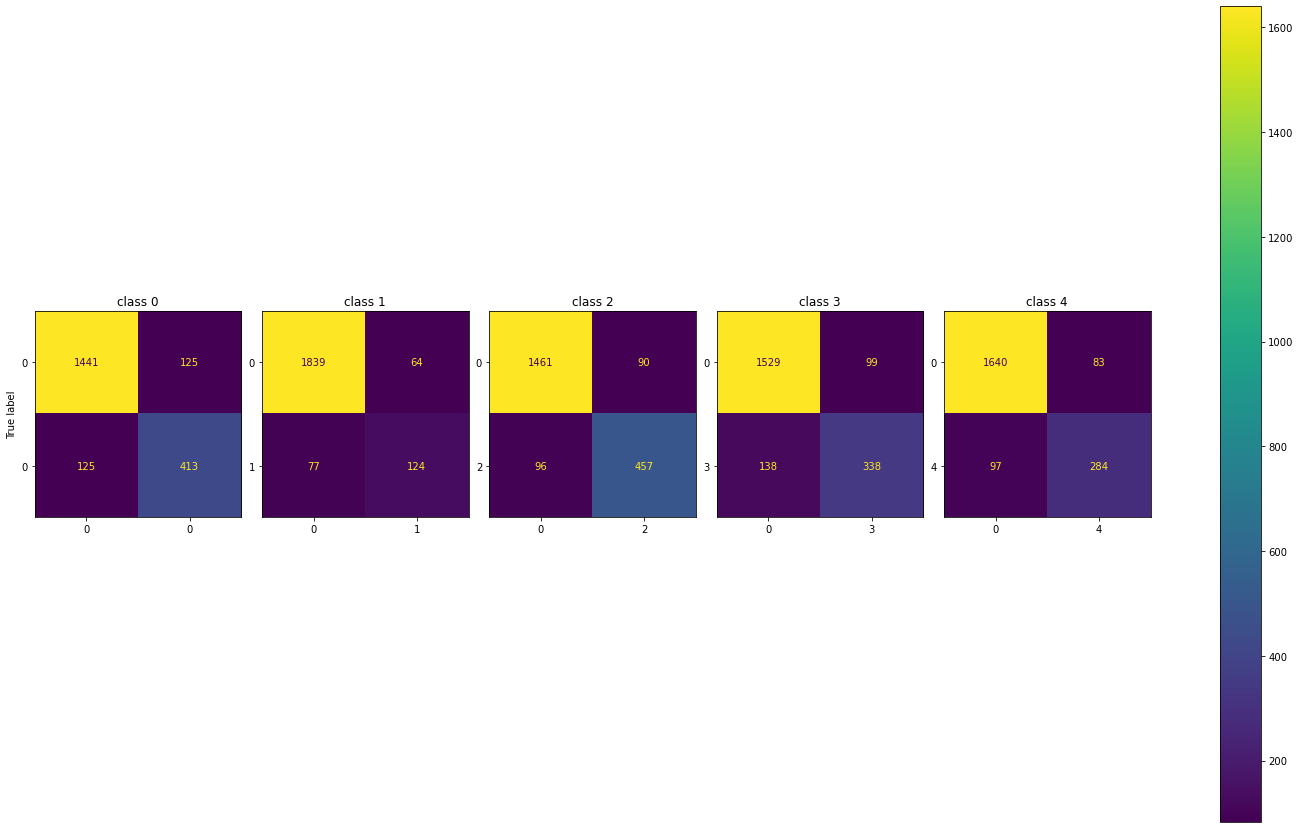

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_multilabel_classification
from sklearn.tree import DecisionTreeClassifier

f, axes = plt.subplots(1, 5, figsize=(25, 15))
axes = axes.ravel()
for i in range(5):
    disp = ConfusionMatrixDisplay(confusion_matrix(test_labels[:, i],
                                                   y_pred[:, i]),
                                  display_labels=[0, i])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'class {i}')
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()